### SHRED applied to Øresund

This iPython notebook gives an introductory walkthrough to using SHRED models.  

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mikeio


num_sensors = 3 
lags = 52

sensor_locations = np.array([2849,   41, 2452])
np.save("Data/sensor_locations.npy",sensor_locations)


In [11]:
ds = mikeio.read("Data/Area.dfsu",time=slice("2022-01-01", "2022-04-30"), items=[0])
# ds.to_dfs("Data/Area_5m.dfsu")
load_X = ds[0].to_numpy()
load_X.shape
n = load_X.shape[0]
m = load_X.shape[1]

We now select indices to divide the data into training, validation, and test sets.

In [7]:
# FRTP:
n_test = 174
n_valid = 174
n_train = 1000

train_indices = np.arange(0, n_train)
valid_test_indices = np.arange(n_train,n_train+n_valid)
test_indices = np.arange(n_train+n_valid,n_train+n_valid+n_test)


In [ ]:
np.load("ReconstructingResults/sensor_locations.npy")

array([2849,   41, 2452])

In [14]:
reconstruction = np.load('ReconstructingResults/reconstructions.npy')
truths = np.load('ReconstructingResults/truth.npy')
sensor_locations = np.load('ForecastingResults/sensor_locations.npy')

In [ ]:
# Default from paper ?!?!?!
# Test Reconstruction Error: 
# 0.0193155

# When train and test are clearly separated:
# Test Reconstruction Error: 
# 0.04866559

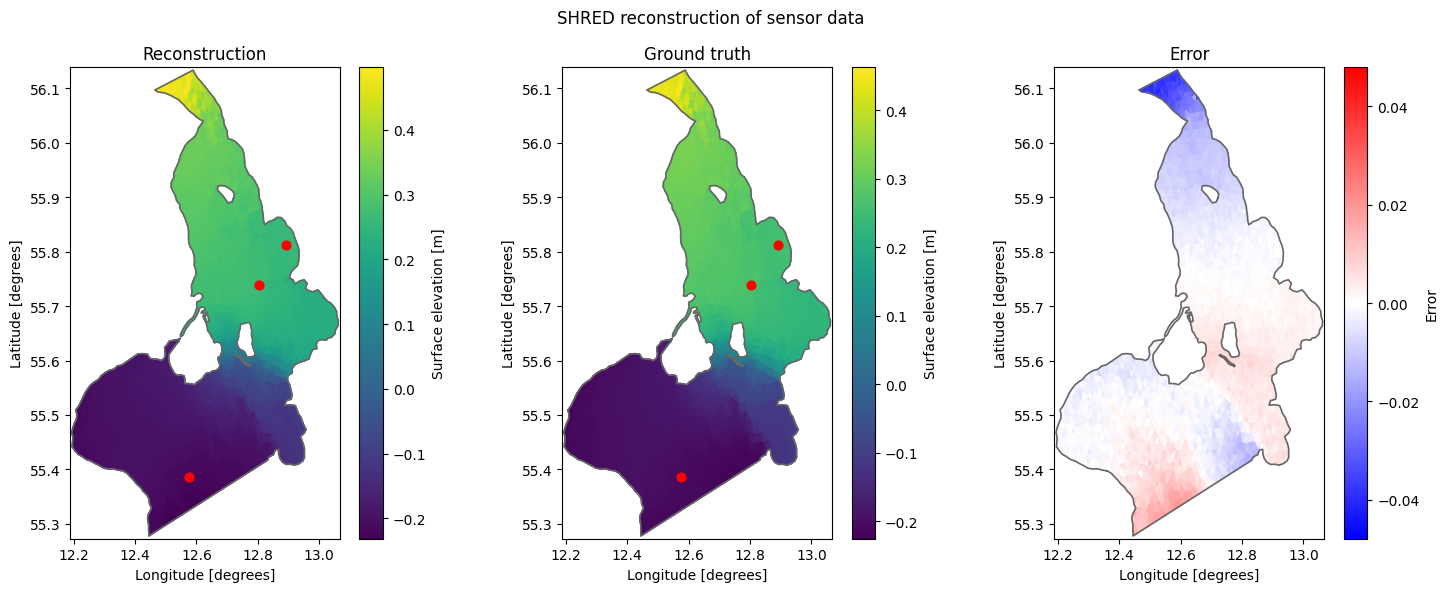

In [15]:
elem_cor = ds[0].geometry.element_coordinates
plot_index = 10


# Create dataarrays for plotting
da_plot_recon = ds[0].sel(time=ds.time[test_indices[plot_index]+ lags - 1]).copy()
da_plot_true = da_plot_recon.copy()
da_plot_err = da_plot_recon.copy()
# Fill with values from the reconstruction and the ground truth, as well as errors
da_plot_recon.values = reconstruction[plot_index]
da_plot_true.values = truths[plot_index]
da_plot_err.values =  truths[plot_index]-reconstruction[plot_index]
# min and max values for the colorbar
vmin = -max(abs(np.min(da_plot_err.values)),abs(np.max(da_plot_err.values)))
vmax = max(abs(np.min(da_plot_err.values)),abs(np.max(da_plot_err.values)))

fig,axs = plt.subplots(1,3,figsize=(15,6))
fig.suptitle('SHRED reconstruction of sensor data')

da_plot_true.plot(ax = axs[1],add_colorbar=False)
cbar = fig.colorbar(axs[1].collections[0], ax=axs[1],label='Surface elevation [m]')
axs[1].set_title('Ground truth')

da_plot_err.plot(ax = axs[2],cmap="bwr",vmin=vmin,vmax=vmax,add_colorbar=False)
cbar = fig.colorbar(axs[2].collections[0], ax=axs[2],label='Error')
axs[2].set_title('Error')

da_plot_recon.plot(ax = axs[0],add_colorbar=False)
cbar = fig.colorbar(axs[0].collections[0], ax=axs[0],label='Surface elevation [m]')
axs[0].set_title('Reconstruction')

# Add a red dot to the spatial points indicated by the sensor locations
for i in range(num_sensors):
    axs[0].scatter(elem_cor[sensor_locations[i],0], elem_cor[sensor_locations[i],1], color='red', s=40, label='Sensor location')
    axs[1].scatter(elem_cor[sensor_locations[i],0], elem_cor[sensor_locations[i],1], color='red', s=40, label='Sensor location')

plt.tight_layout()



In [16]:
rmspe = np.sqrt(np.mean(np.square((da_plot_err.values / da_plot_true.values)), axis=0))
rmse = np.sqrt(np.mean(np.square((da_plot_err.values)), axis=0))

print('RMSPE: ', rmspe,' \nRMSE:  ', rmse)

RMSPE:  0.13950521  
RMSE:   0.008263989
